In [12]:
import numpy as np
import scipy
import time
import math
import itertools
from scipy.stats import norm
from pathlib import Path

# import mystic
# from mystic.solvers import DifferentialEvolutionSolver, diffev2,fmin
# from mystic.strategy import Best1Bin
# from mystic.monitors import Monitor,VerboseMonitor


from copy import deepcopy

from tomography import *

from nestedforloop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from efficiencies import *
from optimization import Optimizer, function_fidelity_U, FidelityResults, function_fidelity_Rz
from constants import *

from densitymatrix import DensityMatrix, apply_unitary_to_dm
from pathlib import Path
import fnmatch

In [2]:
working_dir = os.getcwd()
working_dir_data = r"/home/henrique/Documents/Personal/Laura/Tomography/Data/QST_Final"

n_files=0
os.chdir(working_dir_data)

filenames = [i for i in glob.glob("QST*")]
filenames.sort(key=lambda x: float((x.split("=")[1].split("s")[0])))

# print(filenames)

In [3]:
######################################################################################################
#----- COUNTING THE FILES AND SAVING THEM IN AN ARRAY TO MAKES THE REST OF THE ANALYSIS EASIER -------
######################################################################################################

index_to_file = {}
n_files = 0

for index, file in enumerate(filenames):
    os.chdir(f"{working_dir_data}/{file}")
    file_aux=[i for i in glob.glob("counts*")]
    for index_second, file_aux_second in enumerate(file_aux):
        index_to_file[n_files] = f"{file}/{file_aux_second}"
        n_files+=1
        
os.chdir(working_dir)
print("Files to analyse: ", index_to_file)

Files to analyse:  {0: 'QST_GHZ_aqtime=15.0s_20240426113453/counts', 1: 'QST_GHZ_aqtime=33.0s_20240426140145/counts', 2: 'QST_GHZ_aqtime=48.0s_20240426154101/counts', 3: 'QST_GHZ_aqtime=66.0s_20240427131749/counts', 4: 'QST_GHZ_aqtime=125.0s_20240427164403/counts', 5: 'QST_GHZ_aqtime=150.0s_20240427204300/counts', 6: 'QST_GHZ_aqtime=600.0s_20240426180903/counts'}


In [4]:
#####################################################################
#---------------------- DEFINING PARAMS ----------------------------#
#####################################################################
os.chdir(working_dir)
qubit_number=4

## Defining the columns of the data file we want to use as data to reconstruct the density matrix (eg.: HH HV VH and VV basis)
BASIS_TO_CHANNEL={
    "HA": 1,
    "VA": 2,
    "HB": 3,
    "VB": 4,
    "HC": 5,
    "VC": 6,
    "HD": 7,
    "VD": 8,
    }

### 4 qubits GHZ ###
eigenstates = [['HA','HB','HC','HD'],['HA','HB','HC','VD'],['HA','HB','VC','HD'],['HA','HB','VC','VD'],
               ['HA','VB','HC','HD'],['HA','VB','HC','VD'],['HA','VB','VC','HD'],['HA','VB','VC','VD'],
               ['VA','HB','HC','HD'],['VA','HB','HC','VD'],['VA','HB','VC','HD'],['VA','HB','VC','VD'],
               ['VA','VB','HC','HD'],['VA','VB','HC','VD'],['VA','VB','VC','HD'],['VA','VB','VC','VD']]

fold = four_fold=[[BASIS_TO_CHANNEL[eigenstates[i][j]] for j in range(qubit_number)] for i in range(len(eigenstates))]

In [5]:
datafile_channels = fold.copy()

for clicks in fold:
    not_in_clicks = list(set(range(1, 2*qubit_number+1)) - set(clicks))
    not_in_clicks.sort()
    for rep in range(1, len(not_in_clicks)+1):
        for combo in itertools.combinations(not_in_clicks, rep):
            new_clicks = clicks + list(combo)
            new_clicks.sort()
            datafile_channels.append(new_clicks)
            
datafile_channels = np.array(list(set(map(tuple, datafile_channels))), dtype=object)
first_order = list(map(len, datafile_channels)) 
order = np.lexsort((datafile_channels, first_order))
datafile_channels = list(datafile_channels[order])
datafile_channels = [list(t) for t in datafile_channels]

In [6]:
coincidences_columns = []

for i, iter in enumerate(eigenstates):
    proj = [BASIS_TO_CHANNEL[iter[m]] for m in range(qubit_number)]
    coincidences_columns.append(datafile_channels.index(proj))
#     print(coincidence_columns)

column_start = np.min(coincidences_columns)
column_stop = np.max(coincidences_columns) + 1
print("Coincidences column_start:", column_start,"; column_stop: ", column_stop)

column_start_5_emissions = 2**qubit_number
column_stop_5_emissions = 2**qubit_number*qubit_number + column_start_5_emissions

column_start_6_emissions = column_stop_5_emissions
column_stop_6_emissions =  column_stop_5_emissions + 64*3

print("Coincidences column_start:", column_start_5_emissions,"; column_stop: ", column_stop_5_emissions)
print("Coincidences column_start:", column_start_6_emissions,"; column_stop: ", column_stop_6_emissions)

Coincidences column_start: 0 ; column_stop:  16
Coincidences column_start: 16 ; column_stop:  80
Coincidences column_start: 80 ; column_stop:  272


In [7]:
state_2emission_correction = []

xp_counts_corrected_with_eff=[]
xp_counts_corrected_with_eff_2e=[]

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################
for index in range(len(index_to_file)):
    os.chdir(f"{working_dir_data}/{index_to_file[index]}/")
    datafiles=[i for i in glob.glob("*")]
    
    ### Calculating the efficiencies of each detector
    efficiencies=get_channels_eff(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    efficiencies_5_emissions=get_channels_eff(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    efficiencies_6_emissions=get_channels_eff(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
   
    #print(f"Channels efficiencies: {efficiencies}")

    ### Opening the data files and writing the data in counts_aux array
    counts_aux=set_raw_counts(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    xp_counts=np.array(np.transpose(counts_aux))
    total_per_basis=np.sum(xp_counts, axis=1)
 
    counts_aux_5_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    xp_counts_5_emissions=np.array(np.transpose(counts_aux_5_emissions))

    counts_aux_6_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
    xp_counts_6_emissions=np.array(np.transpose(counts_aux_6_emissions))

    # Running QST while correcting for double emission counts
    statetomo = LRETomography(int(qubit_number), xp_counts, xp_counts_5_emissions,xp_counts_6_emissions)
    statetomo.run(correct_eff=efficiencies,correct_double_emission_eff=efficiencies_5_emissions, four_emission_eff=efficiencies_6_emissions,GHZ = True)
    xp_counts_corrected_with_eff_2e.append(statetomo.xp_counts)
        
    state_2emission_correction.append(statetomo)

/home/henrique/Documents/Personal/Laura/Tomography/efficiencies.py:173: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  counts_aux=counts[[tuple(indice)]]
/home/henrique/Documents/Personal/Laura/Tomography/projectorcounts.py:143: RuntimeWarning: invalid value encountered in true_divide
  self.counts_array_4_emissions[w] = self.counts_array_4_emissions[
/home/henrique/Documents/Personal/Laura/Tomography/projectorcounts.py:143: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_array_4_emissions[w] = self.counts_array_4_emissions[
/home/henrique/Documents/Personal/Laura/Tomography/projectorcounts.py:139: RuntimeWarning: invalid value encountered in true_divide
  self.counts_array_2_emissions[w] = self.counts_array_2_emissions[
/home/henrique/Doc

In [8]:
state_no_correction = []

xp_counts_corrected_with_eff=[]
xp_counts_corrected_with_eff_2e=[]

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################
for index in range(len(index_to_file)):
    os.chdir(f"{working_dir_data}/{index_to_file[index]}/")
    datafiles=[i for i in glob.glob("*")]
    
    ### Calculating the efficiencies of each detector
    efficiencies=get_channels_eff(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    efficiencies_5_emissions=get_channels_eff(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    efficiencies_6_emissions=get_channels_eff(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
   
    #print(f"Channels efficiencies: {efficiencies}")

    ### Opening the data files and writing the data in counts_aux array
    counts_aux=set_raw_counts(datafiles, qubit_number, column_start, column_stop, os.getcwd())
    xp_counts=np.array(np.transpose(counts_aux))
    total_per_basis=np.sum(xp_counts, axis=1)
 
    counts_aux_5_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_5_emissions, column_stop_5_emissions, os.getcwd())
    xp_counts_5_emissions=np.array(np.transpose(counts_aux_5_emissions))

    counts_aux_6_emissions=set_raw_counts_double_emissions(datafiles, qubit_number, column_start_6_emissions, column_stop_6_emissions, os.getcwd())
    xp_counts_6_emissions=np.array(np.transpose(counts_aux_6_emissions))
    
    #Running QST not correcting for double emission counts
    statetomo1 = LRETomography(int(qubit_number), xp_counts, xp_counts_5_emissions,xp_counts_6_emissions)
    statetomo1.run(correct_eff=efficiencies)
    xp_counts_corrected_with_eff.append(statetomo1.xp_counts)
    state_no_correction.append(statetomo1)

In [9]:
######################################
#-- DEFINING THE TARGET BELL STATE ---
######################################

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

states=state_no_correction
print(f"Fidelity with no double emission (no unitary correction):")
for i, state in enumerate(states):
     print(f"{filenames[i]}: {np.real(np.round(state.state.fidelity(bell),5))}")

Fidelity with no double emission (no unitary correction):
QST_GHZ_aqtime=15.0s_20240426113453: 0.89712
QST_GHZ_aqtime=33.0s_20240426140145: 0.92018
QST_GHZ_aqtime=48.0s_20240426154101: 0.92627
QST_GHZ_aqtime=66.0s_20240427131749: 0.93066
QST_GHZ_aqtime=125.0s_20240427164403: 0.94117
QST_GHZ_aqtime=150.0s_20240427204300: 0.94113
QST_GHZ_aqtime=600.0s_20240426180903: 0.94678


In [10]:
######################################
#-- DEFINING THE TARGET BELL STATE ---
######################################

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

states = state_2emission_correction
print(f"Fidelity with double emission correction (no unitary correction):")
for i, state in enumerate(states):
     print(f"{filenames[i]}: {np.real(np.round(state.state.fidelity(bell),5))}")

Fidelity with double emission correction (no unitary correction):
QST_GHZ_aqtime=15.0s_20240426113453: 0.92086
QST_GHZ_aqtime=33.0s_20240426140145: 0.93501
QST_GHZ_aqtime=48.0s_20240426154101: 0.93905
QST_GHZ_aqtime=66.0s_20240427131749: 0.93912
QST_GHZ_aqtime=125.0s_20240427164403: 0.94813
QST_GHZ_aqtime=150.0s_20240427204300: 0.94589
QST_GHZ_aqtime=600.0s_20240426180903: 0.9495


In [11]:
print(type(state_no_correction[0]))

<class 'tomography.LRETomography'>


In [15]:
##########################################################
#------------------------ ERRORS ------------------------#
##########################################################
error_runs=500

U=[]
bell_aux=[]
target_ini=[]

states=state_no_correction
players=["Arya", "Bran", "Cersei", "Dany"]

for index, state in enumerate(states):
    data_path = Path(working_dir_data+"/"+str(filenames[index]))
    os.chdir(data_path)
    target=bellmatrix
    # U.append(results[index].u)
    # target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1])
    target_ini.append(bellmatrix)
    
    state.calculate_fidelity_error(players, error_runs, target)
    
    print('file, fidelity, fidelity_mean, fidelity_std: ',
          filenames[index], np.round(state.state.fidelity(target_ini[-1]),5), -np.round(state.fidelity_mu,5),
          np.round(state.fidelity_std,6), '\n')
    
    # f = f"{working_dir_data}\\{index_to_file[n_files]}\\final_results"
    with open(data_path/"final_results.txt", mode="w") as f:
        d=f'file, fidelity, fidelity_mean, fidelity_std: {filenames[index]}, {np.round(state.state.fidelity(target_ini[-1]),5)}, {-np.round(state.fidelity_mu,5)}, {np.round(state.fidelity_std,6)}'    
        f.write(d)

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=15.0s_20240426113453 (0.89758+0.00014j) -0.8916 0.001869 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=33.0s_20240426140145 (0.92106-0j) -0.91351 0.001585 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=48.0s_20240426154101 (0.92694-0.00025j) -0.91933 0.001622 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=66.0s_20240427131749 (0.93098+0.00041j) -0.92251 0.001871 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=125.0s_20240427164403 (0.94125-0.0003j) -0.93308 0.001594 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=150.0s_20240427204300 (0.9415

In [16]:
##########################################################
#------------------------ ERRORS ------------------------#
##########################################################
error_runs=500

U=[]
bell_aux=[]
target_ini=[]

states = state_2emission_correction
players=["Arya", "Bran", "Cersei", "Dany"]

for index, state in enumerate(states):
    data_path = Path(working_dir_data+"/"+str(filenames[index]))
    os.chdir(data_path)
    target=bellmatrix
    # U.append(results[index].u)
    # target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1])
    target_ini.append(bellmatrix)
    
    state.calculate_fidelity_error(players, error_runs, target)
    
    print('file, fidelity, fidelity_mean, fidelity_std: ',
          filenames[index], np.round(state.state.fidelity(target_ini[-1]),5), -np.round(state.fidelity_mu,5),
          np.round(state.fidelity_std,6), '\n')
    
    # f = f"{working_dir_data}\\{index_to_file[n_files]}\\final_results"
    with open(data_path/"final_results_corrected.txt", mode="w") as f:
        d=f'file, fidelity, fidelity_mean, fidelity_std: {filenames[index]}, {np.round(state.state.fidelity(target_ini[-1]),5)}, {-np.round(state.fidelity_mu,5)}, {np.round(state.fidelity_std,6)}'    
        f.write(d)

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=15.0s_20240426113453 (0.92148+0.00032j) -0.91438 0.001713 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=33.0s_20240426140145 (0.93506+0.00036j) -0.92762 0.001639 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=48.0s_20240426154101 (0.93954+2e-05j) -0.93135 0.001656 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=66.0s_20240427131749 (0.93959+0.00028j) -0.93038 0.001769 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=125.0s_20240427164403 (0.94867-0.00022j) -0.93943 0.001612 

Simulating new states considering the uncertainties
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=150.0s_20240427204300 (

In [24]:
# ##########################################################
# #----- OPTIMIZATION OF MAX FIDELITY UP TO UNITARIES ------
# ##########################################################
# states=state
# fid=np.zeros((n_files))
# optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')

# guess=np.zeros(3*(qubit_number-1))
# bounds=[(-np.pi,np.pi)]*3*(qubit_number-1)
# results = []

# opt=Optimizer(guess, function_fidelity_U, results=FidelityResults)
# for index in range(len(states)):
#     result=opt.optimize(qubit_number,states[index].state, bell, bounds=bounds)
#     results.append(result)

Simulating new states considering the uncertainties
Optimizing the fidelity between input and target up to a unitary
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_aqtime=24.0s_20240426123457\counts (0.93241+0j) 0.92645 0.001573 



Filename - no unitary optimization:  QST_GHZ_aqtime=24.0s_20240426123457
Average Rate: (107.15072016460904 +/- 2.218472607239523) Hz
Fidelity with no unitary correction = (0.93241+0j)%


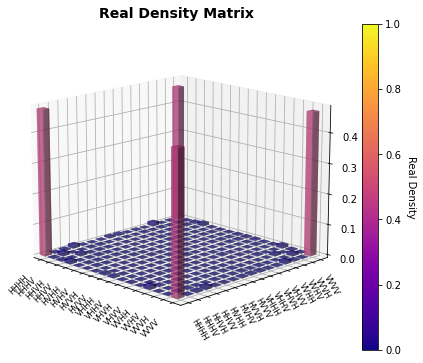

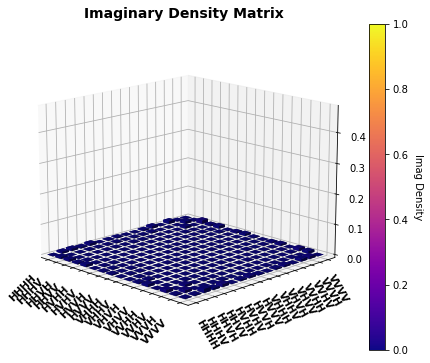

Filename - unitary optimization:  QST_GHZ_aqtime=24.0s_20240426123457
Filename:  QST_GHZ_aqtime=24.0s_20240426123457
Average Rate: (107.15072016460904 +/- 2.218472607239523) Hz
Fidelity with unitary optimization = (0.93241+0j)%


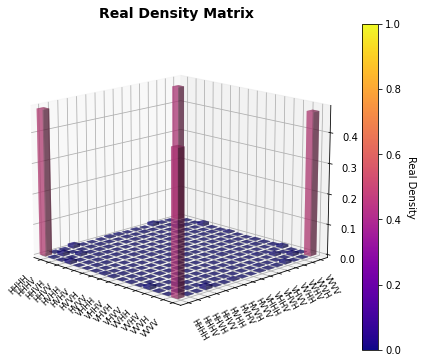

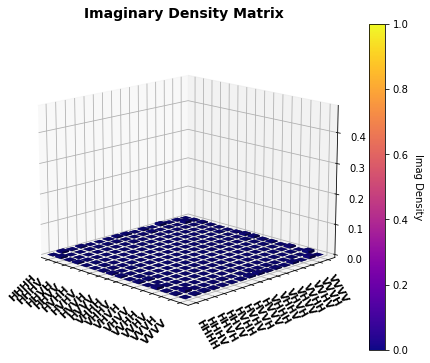

In [76]:
##########################################################
#--------------- PLOTTING DENSITY MATRIX-----------------#
##########################################################
print("Filename - no unitary optimization: ", file)
aq_time=24 #in seconds
print(f"Average Rate: ({np.average(total_per_basis)/aq_time} +/- {np.std(total_per_basis)/aq_time}) Hz")
print(f"Fidelity with no unitary correction = {np.round(states[-1].state.fidelity(bellmatrix),5)}%")
state[-1].state.plot_dm()

print("Filename - unitary optimization: ", file)
print("Filename: ", file)

print(f"Average Rate: ({np.average(total_per_basis)/aq_time} +/- {np.std(total_per_basis)/aq_time}) Hz")
print(f"Fidelity with unitary optimization = {np.round(states[index].state.fidelity(target_ini[-1]),5)}%")
results[-1].optimized_state.plot_dm()

NameError: name 'cmap' is not defined

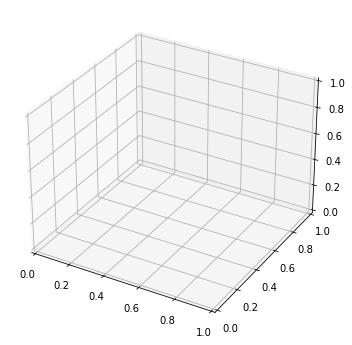

In [36]:
density_matrix_plot = state[-1].state.state
real_density_matrix = density_matrix_plot.real
imag_density_matrix = density_matrix_plot.imag
HV_label = {0: "H", 1: "V"}

HV_iterator = get_iterator(2, 4)
axes_labels = []
for k in range(np.shape(density_matrix_plot)[0]):
    axes_labels.append("".join(tuple(map(HV_label.get, HV_iterator[k]))))

nrows, ncols = density_matrix_plot.shape

# Create a meshgrid for the x and y values
x = np.arange(ncols)
y = np.arange(nrows)
X, Y = np.meshgrid(x, y)

# Flatten the density matrix values
Z = real_density_matrix.flatten()
W = imag_density_matrix.flatten()

# Set the column heights as Z values
column_heights = abs(Z)
column_heights2 = abs(W)

# Set the column widths and depths
column_width = column_depth = 0.7

# Create the first figure
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')

# Plot the density matrix as 3D columns using a colormap
# cmap = cm.get_cmap('plasma')
# cmap = cm.get_cmap('set3')
ax1.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z), column_width, column_depth, column_heights, shade=True, color=cmap(Z), alpha=0.5)

ax1.set_xticks(np.arange(ncols) + 0.5)
ax1.set_yticks(np.arange(nrows) + 0.5)
ax1.set_xticklabels(axes_labels, rotation=45, ha='right', fontsize=8, fontweight='light')
ax1.set_yticklabels(axes_labels, rotation=-60,fontsize=8, fontweight='light')

# Set the title
ax1.set_title('Real Density Matrix', fontsize=14, fontweight='bold')

# Add a colorbar
# cbar = fig1.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax1)
# cbar.set_label('Real Density', rotation=270, labelpad=15)

# Adjust plot limits to avoid cutoff of tick labels
ax1.set_xlim(0, ncols)
ax1.set_ylim(0, nrows)
ax1.view_init(elev=15, azim=-45)
# Create the second figure
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection='3d')

# Plot the density matrix as 3D columns using a colormap
ax2.bar3d(X.ravel(), Y.ravel(), np.zeros_like(W), column_width, column_depth, column_heights2, shade=True, color=cmap(W),zsort='max')

# Set the x and y axis labels
ax2.set_xticks(np.arange(ncols) + 0.5)
ax2.set_yticks(np.arange(nrows) + 0.5)
ax2.set_xticklabels(axes_labels, rotation=45, ha='right', fontsize=8)#, fontweight='bold')
ax2.set_yticklabels(axes_labels, rotation=-60, fontsize=8)#, fontweight='bold')
ax2.set_zlim(0, np.max([column_heights, column_heights2]))  # Set z-axis limits

# Set the title
ax2.set_title('Imaginary Density Matrix', fontsize=14, fontweight='bold')

# # Add a colorbar
# cbar = fig2.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax2)
# cbar.set_label('Imag Density', rotation=270, labelpad=15)

# Adjust plot limits to avoid cutoff of tick labels
ax2.set_xlim(0, ncols)
ax2.set_ylim(0, nrows)
ax2.view_init(elev=15, azim=-45)
# Display the figures

plt.savefig(r"D:\Multipartite Entanglement Experiment\Data\QST\dm_im.svg")
plt.show()

In [ ]:
# results[-1].optimized_state.state

In [336]:
import functools as ft


sigma_y = np.array([[0,-1j],[1j,0]])
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_h = (sigma_x + sigma_y)/np.sqrt(2)
sigma_v = (sigma_x - sigma_y)/np.sqrt(2)
hadamard = np.array([[1,1],[1,-1]])
Id = np.array([[1,0],[0,1]])
Id_8 = np.identity(16)

def W_qubit_T():
    
    def A0():
        return(sigma_x)
    def A1():
        return(sigma_y)
    def B0():
        return(sigma_x)
    def B1():
        return(sigma_y)
    def C0():
        return(sigma_x)
    def C1():
        return(sigma_y)    
    def D0():
        return(sigma_x)
    def D1():
        return(sigma_y)

    return(
           ft.reduce(np.kron,(A0(),B0(),C0(),D0()))-
           ft.reduce(np.kron,(A1(),B1(),C0(),D0()))-
           ft.reduce(np.kron,(A1(),B0(),C1(),D0()))-
           ft.reduce(np.kron,(A1(),B0(),C0(),D1()))+
           ft.reduce(np.kron,(A1(),B1(),C1(),D1()))-
           ft.reduce(np.kron,(A0(),B1(),C1(),D0()))-
           ft.reduce(np.kron,(A0(),B1(),C0(),D1()))-
           ft.reduce(np.kron,(A0(),B0(),C1(),D1())))

np.trace(W_qubit_T()@results[-1].optimized_state.state)

(7.362206996561801-6.661338147750939e-16j)

In [314]:
state[-1].state

array([[ 4.77517868e-01-1.93256663e-17j, -3.61839462e-02-2.17929919e-02j,
         2.58549203e-03-1.19153698e-02j, -7.17647553e-03-6.64690755e-03j,
        -1.94921217e-03-1.60325974e-02j,  9.67776036e-04+1.41578692e-03j,
         2.44525460e-03-2.02860372e-03j,  4.60595447e-03-2.15198767e-02j,
        -1.59220797e-02-1.19748861e-02j, -1.22230393e-03+2.52159795e-03j,
        -7.47680427e-05-2.28945987e-04j, -5.16079400e-03-1.31668876e-02j,
         3.47390541e-03-7.56391204e-03j,  1.60592471e-04-1.17216138e-03j,
         2.19075512e-02-2.77538564e-02j,  3.13547314e-01-3.23602048e-01j],
       [-3.61839462e-02+2.17929919e-02j,  1.56700805e-02+8.53782350e-18j,
         3.75747588e-03-4.53688183e-04j,  1.12541086e-04-1.88057119e-03j,
         4.18038981e-03-2.51851491e-03j, -1.93443875e-04-2.56899567e-03j,
         1.97150299e-03+6.11457188e-04j, -5.77967682e-04+4.24802265e-03j,
        -4.85350191e-04+1.36251360e-03j, -6.83871897e-04-2.43653203e-03j,
        -1.98730255e-04-1.32869457e-0

In [315]:
results[-1].u2

array([[ 0.51270881+0.8579609j,  0.02097725-0.0243459j],
       [-0.02097725-0.0243459j,  0.51270881-0.8579609j]])

In [241]:
results[-1].u3

array([[ 0.98758376-0.14645173j,  0.05408303-0.01747068j],
       [-0.05408303-0.01747068j,  0.98758376+0.14645173j]])

In [ ]:
#### Everything under this line was used to analyse the quantum transmission certification

In [ ]:
##########################################################
#--------------- ERRORS OUTPUT TO INTPUT ----------------#
##########################################################
U=[]
bell_aux=[]
target_ini=[]

states=state_before

for index in range(len(states)):
    target=state_after[index]
    U.append(np.kron(results[index].u1,results[index].u2))
    target_ini.append(np.transpose(np.conjugate(U[-1]))@state_after[index].state.state@U[-1])
    
    states[index].calculate_fidelity_error_between_2_experimental_matrices(error_runs, players, target, apply_unitary_to_input=True)
    
    print('file, fidelity, fidelity_mean, fidelity_std: ',
          state_after_file[index], np.round(states[index].state.fidelity(target_ini[-1]),5), -np.round(states[index].fidelity_2_experimental_dms_mu,5),
          np.round(states[index].fidelity_2_experimental_dms_std,5), "\n")

In [ ]:
bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

result=opt.optimize(state_before[2].state, bell, bounds=bounds)
U[2]=np.kron(result.u1,result.u2)

t=state_after[2].state.state

t_ini=np.linalg.inv(U[2])@state_after[2].state.state@np.linalg.inv(np.transpose(np.conjugate(U[2])))

states[2].calculate_fidelity_error(players, error_runs, opt, t, bounds=bounds)

print('index, fidelity, fidelity_mean, fidelity_std: ',
        state_before_file[index], np.round(states[2].state.fidelity(t_ini),5), np.round(states[2].fidelity_mu,5),
        np.round(states[2].fidelity_std,5))

In [ ]:
##########################################################
#------------ ERRORS OUTPUT with BELL STATE--------------#
##########################################################
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))
error_runs=1

U=[]
bell_aux=[]
target_ini=[]

states=state_after
players=["Arya", "Cersei"]

guess=np.array([0, 0, 0])
bounds=[(-np.pi,np.pi)]*3
opt=Optimizer(guess, function_fidelity_Rz, results=FidelityResults)

for index in range(len(states)):
    target=bellmatrix
    #U.append(results[index].u)
    #target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1])    
    
    states[index].calculate_fidelity_error(players, error_runs, opt, target, bounds=bounds)
    
    print('index, fidelity, fidelity_mean, fidelity_std: ',
          state_after_file[index], np.round(states[index].state.fidelity(target),5), np.round(states[index].fidelity_mu,5),
          np.round(states[index].fidelity_std,5))

In [ ]:
bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))
target=bellmatrix

result=opt.optimize(state_before[2].state, bell, bounds=bounds)

t=state_after[2].state.state

states[2].calculate_fidelity_error(players, error_runs, opt, t, bounds=bounds)

print('index, fidelity, fidelity_mean, fidelity_std: ',
        state_after_file[index], np.round(states[2].state.fidelity(target),5), np.round(states[2].fidelity_mu,5),
        np.round(states[2].fidelity_std,5))

In [ ]:
##########################################################
#------------ WRITING THE DATA IN AN EXCEL ---------------
##########################################################

import xlsxwriter
states=state_before

workbook = xlsxwriter.Workbook('fidelities_to_ini_state_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'Fidelity')
worksheet.write('D1', 'Fidelity_mean')
worksheet.write('E1', 'Fidelity_uncertainty')

counter=0
for index in range(len(state_before)):
    
    worksheet.write('A'+str(counter+2), counter)
    worksheet.write('B'+str(counter+2), state_before_file[index])
    worksheet.write('C'+str(counter+2), np.real(np.round(states_final[index].fidelity(target[index]),5)))#np.round(states[index].fidelity_to_pure(bell),5)))
    worksheet.write('D'+str(counter+2), np.real(np.round(states_final[index].mu,5)))
    worksheet.write('E'+str(counter+2), np.real(np.round(states_final[index].std,5)))
    counter+=1
        
workbook.close()

In [ ]:
### IF WE WANT TO CHECK THE FIT TO THE UNCERTARTAINTY
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(0,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [67]:
import scipy.optimize as sp

In [ ]:
### This was to analyse the quantum channel certification paper
# state_after=[]
# state_after_file=[]

# state_before=[]
# state_before_file=[]

## The 'e' and 'r' serve to distinguish between tomography before and after, respectively
    ## We want to save them in different arrays because we need them for different things
#     elif index_to_file[index][-8]=='e':
#         state_before.append(statetomo[-1])#.state)
#         state_before_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_before[-1], '\n')

#     elif index_to_file[index][-8]=='r':
#         state_after.append(statetomo[-1])#.state)
#         state_after_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_after[-1], '\n')

In [68]:
def Unitary(angle, u):

    a = angle[0]
    b = angle[1]
    y = angle[2]
    
    f = (1/2)*(-np.cos(2*(a-b))-np.cos(2*(b-y))) - np.real(u[0][0])#- np.real(np.exp(-1j*angles/2))
    g = (1/2)*(np.sin(2*(a - b)) + np.sin(2*(b - y))) - np.real(u[0][1])
    h = (1/2)*(-np.sin(2*(a - b)) - np.sin(2*(b - y))) - np.real(u[1][0])
    v = (1/2)*(-np.cos(2*(a-b))- np.cos(2*(b - y))) - np.real(u[1][1])#- np.real(np.exp(1j*angles/2))

    K = (1/2)*(-np.cos(2*b) + np.cos(2*(a - b + y))) - np.imag(u[0][0])#- np.imag(np.exp(-1j*angles/2))
    m = (1/2)*(-np.sin(2*b) + np.sin(2*(a - b + y))) - np.imag(u[0][1])
    z = (1/2)*(-np.sin(2*b) + np.sin(2*(a - b + y)))- np.imag(u[1][0])
    e = (1/2)*(np.cos(2*b) - np.cos(2*(a - b + y))) - np.imag(u[1][1])#- np.imag(np.exp(1j*angles/2))

    return  (f,g,h,v,K,m,z,e)

def solving(angle, u):
    result = sp.least_squares(Unitary,angle,method='trf',args=[u],max_nfev=1000000000)
    QWP1 = result.x[0]
    HWP1 = result.x[1]
    QWP2 = result.x[2]
    return([QWP2*180/np.pi,HWP1*180/np.pi,QWP1*180/np.pi])

In [80]:
solving([0,0,0], results[-1].u1)

[-44.31009555283429, -64.64836099407854, -42.652423014015284]

In [81]:
solving([0,0,0], results[-1].u2)

[-35.96688380260398, -34.03358583266017, -35.70376156589577]

In [82]:
solving([0,0,0], results[-1].u3)

[43.98663508961983, 80.35219612746502, 45.90678416991186]

In [72]:
results[-1].u1


array([[-0.73891984+0.67250778j,  0.02138428+0.0356858j ],
       [-0.02138428+0.0356858j , -0.73891984-0.67250778j]])

In [73]:
results[-1].u2

array([[-0.9980124 -0.05966225j,  0.00458325-0.01976532j],
       [-0.00458325-0.01976532j, -0.9980124 +0.05966225j]])

In [75]:
results[-1].u3

array([[-0.32850122+0.9444377j ,  0.01101316-0.00175683j],
       [-0.01101316-0.00175683j, -0.32850122-0.9444377j ]])

In [76]:
results[-1].u4

array([[1, 0],
       [0, 1]])